In [1093]:
import polars as pl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import sqrt, dot
import seaborn as sns
from sklearn.model_selection import train_test_split

In [1094]:
sns.set_theme()

In [1095]:
def R2(y_pred: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_pred - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def Q2(y_hat: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_hat - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def RMSE(y_hat: pl.Series, y_obs: pl.DataFrame):
    return (((y_hat - y_obs.to_series())**2).sum()/y_obs.shape[0])**0.5

def F(y_pred: pl.Series, y_obs: pl.DataFrame, descriptor_number: int):
    return (((y_pred - y_pred.mean())**2).sum() / (y_pred.shape[0] - 1)) / (((y_obs.to_series() - y_pred)**2).sum() / (y_pred.shape[0] - descriptor_number - 1))

In [1096]:
dane_leki = pl.read_excel(
                source="dane_leki.xlsx",
                columns=list(range(1,7))
).sort(pl.col("logK HSA"))

In [1097]:
dane_leki

Nazwa,logK HSA,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
str,f64,f64,i64,i64,i64
"""metronidazole""",-1.25,-0.97,2,0,6
"""acyclovir""",-1.25,-0.11,3,0,6
"""zidovudine""",-1.25,-0.43,3,0,7
"""acetaminophen""",-0.79,-0.63,2,0,2
"""famotidine""",-0.77,0.01,4,1,5
…,…,…,…,…,…
"""diclofenac""",1.69,1.98,0,1,3
"""indomethacin""",1.82,1.63,1,4,5
"""ibuprofen""",1.84,0.73,0,5,2


In [1098]:
Y = dane_leki.select(pl.col('Nazwa'), pl.col("logK HSA"))

In [1099]:
Y

Nazwa,logK HSA
str,f64
"""metronidazole""",-1.25
"""acyclovir""",-1.25
"""zidovudine""",-1.25
"""acetaminophen""",-0.79
"""famotidine""",-0.77
…,…
"""diclofenac""",1.69
"""indomethacin""",1.82
"""ibuprofen""",1.84


In [1100]:
X = dane_leki.select(
    pl.exclude(["logK HSA", "Zbiór"])
)

In [1101]:
X

Nazwa,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
str,f64,i64,i64,i64
"""metronidazole""",-0.97,2,0,6
"""acyclovir""",-0.11,3,0,6
"""zidovudine""",-0.43,3,0,7
"""acetaminophen""",-0.63,2,0,2
"""famotidine""",0.01,4,1,5
…,…,…,…,…
"""diclofenac""",1.98,0,1,3
"""indomethacin""",1.63,1,4,5
"""ibuprofen""",0.73,0,5,2


In [1102]:
X_trening, X_walidacja, Y_trening, Y_walidacja = train_test_split(X.select(pl.exclude("Nazwa")), Y.select(pl.exclude("Nazwa")), test_size=0.3, shuffle=True)

In [1103]:
X_walidacja

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
0.73,1,0,1
1.25,0,0,3
-0.11,3,0,6
-0.97,2,0,6
1.04,0,6,6
0.57,0,0,2
-0.63,2,0,2
0.01,4,1,5
1.98,0,1,3


In [1104]:
Y_walidacja

logK HSA
f64
1.39
1.08
-1.25
-1.25
2.29
0.67
-0.79
-0.77
1.69


In [1105]:
X_trening

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
0.68,0,0,3
1.48,0,4,8
1.25,1,3,3
-0.63,3,0,5
0.46,0,0,2
…,…,…,…
0.26,2,0,1
1.63,1,4,5
-0.43,3,0,7


In [1106]:
Y_trening

logK HSA
f64
0.69
1.06
1.42
-0.6
0.08
…
-0.42
1.82
-1.25


In [1107]:
corr_matrix = X.select(
    pl.exclude("Nazwa")
).corr()

In [1108]:
corr_matrix

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,f64,f64,f64
1.0,-0.633481,0.446144,-0.135951
-0.633481,1.0,-0.291248,0.290864
0.446144,-0.291248,1.0,0.326375
-0.135951,0.290864,0.326375,1.0


In [1109]:
linear_model = LinearRegression().fit(X_trening, Y_trening)

In [1110]:
linear_model.coef_

array([[ 0.52205213, -0.14056443,  0.27419579, -0.18644421]])

In [1111]:
linear_model.intercept_

array([0.51143621])

In [1112]:
pred_Y_trening = pl.Series(linear_model.predict(X_trening).reshape(-1))
pred_Y_walidacja = pl.Series(linear_model.predict(X_walidacja).reshape(-1))

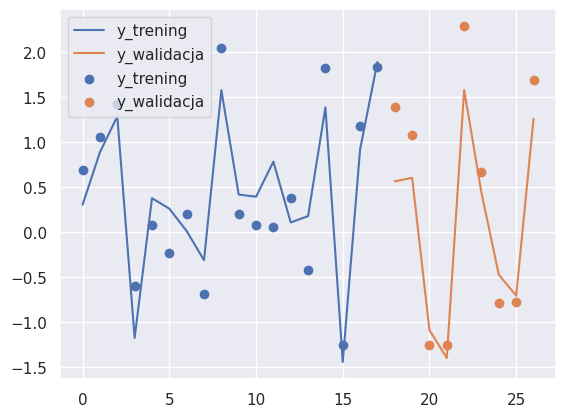

In [1113]:
plt.plot(range(X_trening.shape[0]), pred_Y_trening, label="y_trening")
plt.plot(range(X_trening.shape[0], X_trening.shape[0] + X_walidacja.shape[0]),pred_Y_walidacja, label="y_walidacja")
plt.scatter(range(Y_trening.shape[0]), Y_trening, label="y_trening")
plt.scatter(range(Y_trening.shape[0], Y_trening.shape[0] + Y_walidacja.shape[0]), Y_walidacja, label="y_walidacja")
plt.legend()

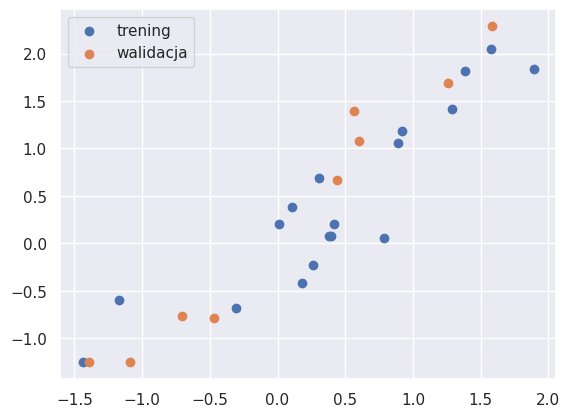

In [1114]:
plt.scatter(pred_Y_trening, Y_trening, label="trening")
plt.scatter(pred_Y_walidacja, Y_walidacja, label="walidacja")
plt.legend()

In [1115]:
h_i_trening = pl.Series(
    dot(

        dot(

            pl.Series(X_trening.cast(pl.Float64).row(i)).reshape((1,-1)), 
            inv(
                dot(

                    X_trening.cast(pl.Float64).transpose(), 
                    X_trening.cast(pl.Float64)
                    
                )
            )

        ),
        pl.Series(X_trening.cast(pl.Float64).row(i))

    )[0] for i in range(X_trening.shape[0])
)

In [1116]:
h_i_trening.head(5)

""
f64
0.12504
0.42304
0.138765
0.29983
0.056033


In [1117]:
h_i_walidacja = pl.Series(
    dot(

        dot(

            pl.Series(X_walidacja.cast(pl.Float64).row(i)).reshape((1,-1)), 
            inv(
                dot(

                    X_walidacja.cast(pl.Float64).transpose(), 
                    X_walidacja.cast(pl.Float64)
                    
                )
            )

        ),
        pl.Series(X_walidacja.cast(pl.Float64).row(i))

    )[0] for i in range(X_walidacja.shape[0])
)

In [1118]:
h_i_walidacja.head(5)

""
f64
0.193303
0.360269
0.335749
0.690901
0.978712


In [1119]:
h_star = 3*(X_trening.shape[1]) / X_trening.shape[0]

In [1120]:
trening_residuals = Y_trening - pred_Y_trening
stan_trening_residuals = trening_residuals.select((pl.col("logK HSA") - trening_residuals.mean()) / trening_residuals.std())

walidacja_residuals = Y_walidacja - pred_Y_walidacja
stan_walidacja_residuals = walidacja_residuals.select((pl.col("logK HSA") - walidacja_residuals.mean()) / walidacja_residuals.std())

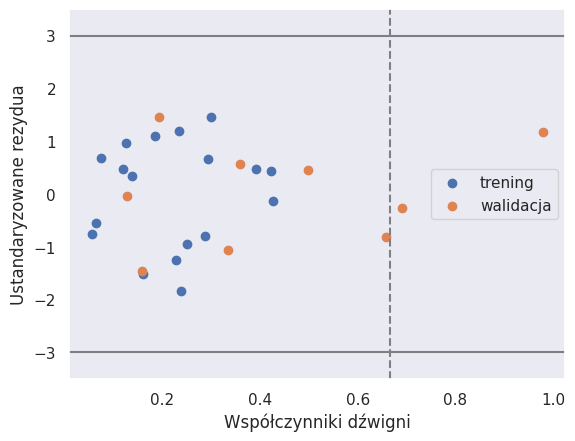

In [1121]:
plt.scatter(h_i_trening, stan_trening_residuals, label="trening")
plt.scatter(h_i_walidacja, stan_walidacja_residuals, label="walidacja")
plt.axvline(h_star, linestyle="dashed", color="grey")
plt.axhline(-3, color='grey')
plt.axhline(3, color='grey')
plt.grid()
plt.ylim(-3.5,3.5)
plt.xlabel("Współczynniki dźwigni")
plt.ylabel("Ustandaryzowane rezydua")
plt.legend()

In [1122]:
R2(pred_Y_trening, Y_trening)

0.827330187545792

In [1123]:
RMSE(pred_Y_trening, Y_trening)

0.3832839988123797

In [1124]:
RMSE(pred_Y_walidacja, Y_walidacja)

0.44743476072902993

In [1125]:
pred_Y_cv = pl.Series([LinearRegression()
    .fit(
        X_trening.with_row_index().filter(pl.col('index') != i).drop('index'),
        Y_trening.with_row_index().filter(pl.col('index') != i).drop('index')
    )
    .predict(
        X_trening.with_row_index().filter(pl.col('index') == i).drop('index')
    )[0][0] for i in range(X_trening.shape[0])] 
    )

In [1126]:
Q2(pred_Y_cv, Y_trening)

0.6776175549059182

In [1127]:
RMSE(pred_Y_cv, Y_trening)

0.5237188103113828

In [1128]:
ex_model = LinearRegression().fit(X_trening, Y_trening)

In [1129]:
pred_Y_ex = pl.Series(ex_model.predict(X_walidacja).reshape(-1))

In [1130]:
Q2(pred_Y_ex, Y_walidacja)

0.8794730964882537

In [1131]:
RMSE(pred_Y_ex, Y_walidacja)

0.44743476072902993

In [1132]:
F(pred_Y_trening, Y_trening, 4)

3.664011977960598